In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [40]:

path = '/Users/satyamkajale/Desktop/pr/lfw'

In [41]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [42]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


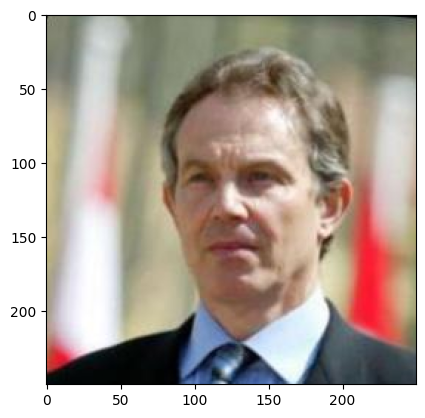

In [43]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Shape of the sample image: torch.Size([3, 250, 250])

Explanation of Dimensions:
1. Channel: Number of color channels in the image.
2. Height: The height of the image in pixels.
3. Width: The width of the image in pixels.


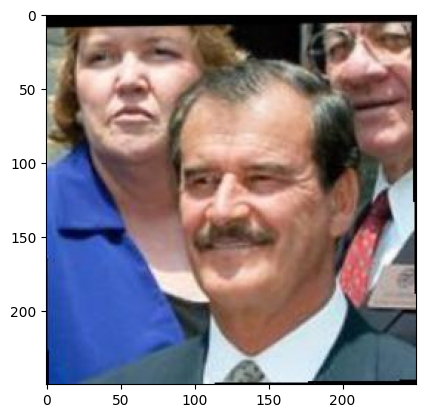

In [44]:
for x, _ in dataloader:
    # Sample of the data
    sample_image = x[0]

    # Dimensions of the image
    print("Shape of the sample image:", sample_image.shape)

    # Explain what each dimension means
    print("\nExplanation of Dimensions:")
    print("1. Channel: Number of color channels in the image.")
    print("2. Height: The height of the image in pixels.")
    print("3. Width: The width of the image in pixels.")

    # Visualize the sample image
    sample_image = sample_image.permute(1, 2, 0) 
    plt.imshow(sample_image)
    plt.show()
    break 


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Decoder Layers
        self.convT1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1)
        self.bn1T = nn.BatchNorm2d(32)
        self.convt2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.bn2T = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        return x

    def decoder(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.bn1T(self.convT1(x)))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.bn2T(self.convt2(x))
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

- Encoder Layers:

  - Convolutional Layer (conv1): self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1): This is a 2D convolutional layer that takes an input with 3 channels (assuming color images) and produces 32 output channels, using a kernel size of 4, a stride of 2, and a padding of 1.

  - Batch Normalization (bn1): self.bn1 = nn.BatchNorm2d(32): This batch normalization layer normalizes the output of the previous convolutional layer, stabilizing and speeding up training.

  - Max Pooling (maxpool1): self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2): This max pooling layer reduces the spatial dimensions (height and width) of the input by half, which helps to reduce the computational load and control overfitting.

  - Second Convolutional Layer (conv2) and Batch Normalization (bn2): Similar to the first set, but with 64 output channels.

- Decoder Layers:

  - Transposed Convolutional Layer (convT1) and Batch Normalization (bn1T): self.convT1 = nn.ConvTranspose2d(...): This transposed convolutional layer helps to increase the spatial dimensions of the input. It's often used in decoder parts of autoencoders to reconstruct the original input size from the compressed representation.

  - Upsampling: F.interpolate(x, scale_factor=2, mode='nearest'): This function call upsamples the input by a factor of 2 using the nearest-neighbor method. It helps to increase the resolution of the input back towards the original input size.

  - Second Transposed Convolutional Layer (convt2) and Batch Normalization (bn2T): A second transposed convolutional layer to further reconstruct the original image dimensions.

- Forward Method: 

  - def forward(self, x): This method defines the forward pass of the network. It takes an input x, passes it through the encoder and then the decoder, and returns the output. The forward method is automatically called when you pass an input to the model instance.

- Activation Functions: 

  - F.relu(...): The ReLU (Rectified Linear Unit) activation function is used after convolutional layers to introduce non-linearities into the model, which allows it to learn more complex patterns.

  - torch.sigmoid(x): The sigmoid activation function is applied at the output of the decoder. It squashes the output to be within the range [0, 1], which is useful if your input images are normalized in this range.

In summary, your AE class defines an autoencoder architecture with two convolutional layers in the encoder and two transposed convolutional layers in the decoder. The encoder compresses the input, and the decoder reconstructs the input from the compressed representation.

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [46]:
# Create an instance of the AE class
model = AE()

In [47]:
if torch.backends.mps.is_available(): 
    device = torch.device("mps")
    model = model.to(device)
else:
    print ("MPS device not found.")

# Initialize a DataLoader to get a batch of images
dataiter = iter(dataloader)
images, _ = dataiter.__next__()

# Move the images to MPS device if available
if torch.backends.mps.is_available():
    images = images.to(device)

# Pass a single image through the model
# You can take the first image from the batch for this example
input_image = images[0].unsqueeze(0)  
encoded = model.encoder(input_image)
decoded = model.decoder(encoded)

# Print the shapes
print("Shape of the output of the encoder:", encoded.shape)
print("Shape of the output of the decoder:", decoded.shape)


Shape of the output of the encoder: torch.Size([1, 64, 31, 31])
Shape of the output of the decoder: torch.Size([1, 3, 250, 250])


- Output Shapes:

  - Encoder Output: Shape of the output of the encoder: torch.Size([1, 64, 31, 31])This shape indicates that the encoder output is a tensor with a batch size of 1, 64 feature maps, and a spatial dimension of 31x31. This is the compressed representation of your input image.

  - Decoder Output: Shape of the output of the decoder: torch.Size([1, 3, 250, 250]) This shape shows that the decoder has successfully reconstructed the image back to its original dimensions (assuming the input images are 250x250 with 3 color channels).

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 68329


In [49]:
import torch.optim as optim

optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
max_vals, min_vals = [], [] # Data inspection - Checking normalization of data
for images, _ in dataloader:
    max_vals.append(images.max().item())
    min_vals.append(images.min().item())

print("Global max pixel value:", max(max_vals))
print("Global min pixel value:", min(min_vals))


Global max pixel value: 1.0
Global min pixel value: 0.0


In [51]:
loss_function = nn.MSELoss()

- Loss Function - Each loss function is designed with specific objectives and assumptions, making them suitable for certain types of tasks. Let's discuss why Cross-Entropy Loss, Hinge Loss, Huber Loss, Negative Log Likelihood (NLL), and KL Divergence might not be as effective as Mean Squared Error (MSE) for your autoencoder task, specifically for a dataset like LFW (Labeled Faces in the Wild) that involves reconstructing human faces.

- MSE Loss - For tasks like image reconstruction where the goal is to accurately replicate pixel values, MSE is often more appropriate compared to loss functions designed for classification(Cross-Entropy Loss), probability distribution comparison(Kullback-Leibler (KL) Divergence), or scenarios where robustness to outliers is a priority(Huber Loss).
  -  Pixel-Wise Reconstruction - MSE is effective for tasks where the goal is to minimize the pixel-wise differences between the reconstructed image and the original image.
  -  Sensitivity to Variation - MSE is sensitive to even small variations in pixel values, which is crucial for high-fidelity image reconstruction.
  - Applicability to Normalized Data - Given that the LFW dataset is normalized between 0 and 1, MSE is well-suited as it directly compares these normalized pixel values.

- Cross-Entropy Loss - Cross-Entropy Loss measures the difference between two probability distributions - the actual label and the predicted label. In an autoencoder, especially for reconstructing images, we are not dealing with probability distributions but rather with the actual pixel values.

- Hinge Loss - Used in regression, particularly robust to outliers, but it is less sensitive to outliers than MSE. In image reconstruction tasks, especially with normalized pixel values, the sensitivity of MSE to all differences (including small ones) can be advantageous for capturing detailed features in faces.

- Negative Log Likelihood (NLL) - NLL Loss is a measure of how well the model predicts the probability of the correct class. It's not designed for the continuous output of pixel values in image reconstruction tasks.

- Considering all the objectives of the model and the nature of the data, I selected MSE loss fot this task.

Reconstruction Loss: The loss function we use to train the autoencoder is highly dependent on the type of input and output we want the autoencoder to adapt to. If we are working with image data, the most popular loss functions for reconstruction are MSE Loss and L1 Loss. Reference - https://v7labs.com/blog/autoencoders-guide#h2


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [53]:
num_epochs = 12

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data

        if torch.backends.mps.is_available():
            device = torch.device("mps")
            inputs = inputs.to(device)

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1, Loss: 0.0014
Epoch 2, Loss: 0.0013
Epoch 3, Loss: 0.0012
Epoch 4, Loss: 0.0012
Epoch 5, Loss: 0.0011
Epoch 6, Loss: 0.0011
Epoch 7, Loss: 0.0011
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0010
Epoch 10, Loss: 0.0010
Epoch 11, Loss: 0.0010
Epoch 12, Loss: 0.0010


Output:

- Decreasing Loss: The loss is consistently decreasing from Epoch 1 through Epoch 12. This is a positive sign, indicating that my model is learning and improving its ability to reconstruct the input images over time.

- Gradual Reduction: The reduction in loss appears to be gradual and steady. This suggests that the learning process is stable. Abrupt changes in loss might indicate issues like an inappropriate learning rate or data anomalies.

- Small Loss Values: The loss values are relatively small (in the range of 0.0010 - 0.0014), which mean that my model is performing well in terms of minimizing the reconstruction error. 

- Learning Rate Efficiency: The consistent decrease in loss also suggests that your learning rate is set appropriately. If the loss were plateauing or oscillating, it might indicate the need to adjust the learning rate.

In my final iteration my model is training well and the loss is decreasing over epochs. But during earlier iterations where the loss was not decreasing as expected, there are several strategies which I employed to troubleshoot and improve my model's performance.

1) AutoEncoder Model Architecture: During my first iterations the model that i made was too complex which ended up giving me loss which was irregular and very high, it resulted into overfitting. Throughout the journey of starting from worst case to reaching best case the model improved from giving increasing loss, irregular outputs, underfitting to Constant decrease in loss. i executed several changes such as experimenting with different weight initialization, adding and experimenting with different layes such as maxpool, avgpool, iterpolate2d, etc. and selected best layer whiuch provide me ideal output. Also, employed and tried working with different activation functions such as Relu, Tanh, Sigmoid which made my model neural networks to process and learn from complex data(images).

2) Along with Conv2D BatchNorm2d and ConvTranspose2d I have used interpolate2d layer because it is a more flexible way of resizing images. It allows for specifying the exact output size or the scale factor for resizing. Interpolation methods like nearest, linear, bilinear, bicubic, and trilinear can be used to calculate the pixel values in the resized image. i have used nearest method.
Why it's useful:
Precise Control Over Output Size: Unlike a fixed upsampling factor, interpolation allows for specific control over the output dimensions, which is crucial in applications where the output size must match a certain requirement.
Quality of Resized Images: Interpolation methods can provide smoother and higher-quality results compared to simple upsampling, especially when enlarging images.

3) Number of layers: Like all neural networks, an important hyperparameter to tune autoencoders is the depth of the encoder and the decoder. While a higher depth increases model complexity, a lower depth is faster to process. I chose to use lower depth to increase the speed of the process and managed to get lower loss over the series of iterations.

4) Data inspection - I checked and made sure data is normalized properly.

5) Learning Rate - I experimented by adjusting learning rate and made sure its not too high or too low to avoid problems like Overshooting the minimum or slow convergence.

6) Batch Size - The choice of batch size is often a balance between computational efficiency, memory constraints, and model performance. It's common to choose a batch size that maximizes the utilization of available hardware resources while also considering the potential impact on model generalization. Experimentation with different batch sizes provided me insights into how batch size affects the particularities of training process and model performance. 

7) Optimizer - Selecting the right optimizer for the autoencoder is essential for effective training. Each optimizer has its own strengths and is suited to different types of problems. I tried using different optimizers with learning rate adjustments and also using parameters like weight decay. But Adam optimizer ended up performing best out of all.



##  Step 7


Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

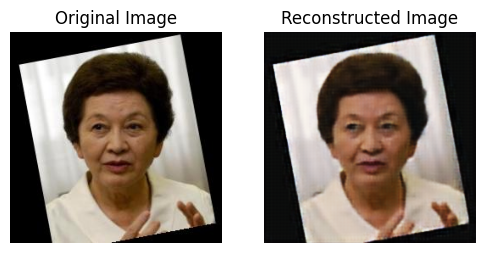

In [109]:
import matplotlib.pyplot as plt
import torch

# Take a random image from the dataset
dataiter = iter(dataloader)
images, _ = dataiter.__next__()
original_image = images[0]

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
original_image = original_image.to(device)
model = model.to(device)

# Function to display an image
def display_image(img, title):
    # Normalize the image for display
    img = (img - img.min()) / (img.max() - img.min())
    # Move channel to the last dimension for plotting
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed_image = model(original_image.unsqueeze(0)).squeeze(0)

# Display the original and reconstructed images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
display_image(original_image, "Original Image")
plt.subplot(1, 2, 2)
display_image(reconstructed_image, "Reconstructed Image")
plt.show()

# Save the original image and its latent representation for Step 8
with torch.no_grad():
    latent_representation = model.encoder(original_image.unsqueeze(0))


- Data Preparation and Device Configuration: You initialize a data iterator from the dataloader and fetch a batch of images. From this batch, you select the first image as your original_image. The device is set to MPS if available, otherwise to CPU. This is where the computations will be performed.

- Display Function: display_image(img, title): A function to display an image. It normalizes the image for display purposes and rearranges the tensor dimensions to be compatible with matplotlib's imshow (which expects the channel dimension last). The image is then displayed without axis and with a given title.

- Image Processing: The original_image is moved to the specified device (mps or cpu). The model is also moved to the same device to ensure consistency. The original_image is passed through the autoencoder within a torch.no_grad() block, which disables gradient calculations (useful for inference to save memory and compute resources). The output reconstructed_image is the result of the autoencoder trying to reconstruct the original image from its encoded representation.

- Latent Representation Saving: The latent representation (the output of the encoder) of the original_image is saved in the variable latent_representation. This is the compressed representation of the original image and can be used for further analysis or processing in later steps.

- Note - The use of torch.no_grad() is crucial for efficient inference, and moving the tensors to the appropriate device (MPS or CPU) ensures optimal utilization of available hardware.

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

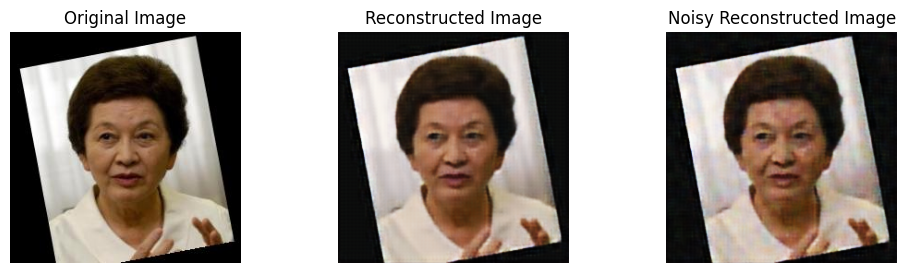

In [110]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Add small normally distributed noise to the latent representation
noise = torch.randn(latent_representation.shape) * 0.1  # 0.1 as a scaling factor for the noise
noisy_latent_representation = latent_representation + noise.to(device)

# Decode both the original and noisy latent representation
with torch.no_grad():
    noisy_reconstructed_image = model.decoder(noisy_latent_representation).squeeze(0)  # Noisy

# Display the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
display_image(original_image, "Original Image")
plt.subplot(1, 3, 2)
display_image(reconstructed_image, "Reconstructed Image")
plt.subplot(1, 3, 3)
display_image(noisy_reconstructed_image, "Noisy Reconstructed Image")
plt.show()


Effect of Noise on Decoded Image

- Blurriness in Reconstructed Images: In comparison to the original, the reconstructed and noisy rebuilt images are both somewhat fuzzy. Autoencoder reconstructions often exhibit this blurriness, especially in shallow or simpler designs. When the autoencoder learns to compress the data into a lower-dimensional latent space, it may lose some of the finer information in the process, which is why the blurriness is an indication of a loss of detail.

- Pixelation in Noisy Reconstructed Image: The additional noise is what causes the pixelation, or discernible little boxes, in the noisy reconstructed image.
The decoder attempts to analyze and recreate the perturbations introduced by noise and bring it back into the image space. This noise appears in the reconstructed image as distortions or pixelation because it doesn't correlate to significant differences in the original data. The decoder's sensitivity to variations in the latent space is demonstrated by this pixelation effect. Tiny modifications in the latent space should cause modest, significant variations in the output in an autoencoder that has been trained properly. However, the distortion results from random noise's inability to reflect significant differences.

Insights Gained: 

- Latent Space Robustness: Introducing noise facilitates testing the latent space's robustness. The ideal latent representation should be moderately resilient to slight noise variations, which means the reconstructed image shouldn't significantly deviate from the original.

- Capacity of the Autoencoder: The autoencoder's capacity may also be shown by the degree of pixelation and blurriness. A more capable autoencoder might better preserve details and be more noise-resistant (possibly with a deeper architecture or more intricate encoding-decoding algorithms).

- Prospects for Denoising: This study serves as a basic idea for denoising autoencoders, which are algorithms taught to eliminate noise from input data. The goal is to teach the network to recognize the underlying patterns in the data by training it to ignore the "noise".

- References - 
 - https://youtu.be/3jmcHZq3A5s?si=eLLh5IQuPIhjd9l8 - Basic understanding of AutoEncoder
 - https://youtu.be/xwrzh4e8DLs?si=MhPmHPuzxJmZLgwk - AutoEncoder Details such as generation, denoising etc
 - https://youtu.be/TtyoFTyJuEY?si=obEmda1O0knjFvlM - Autoencoder execution in python
 - https://youtu.be/6fZdJKm-fSk?si=DvpdpbcP4ZF6rUfW
 - https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/ - Autoencoder generation using Pytorch
 - https://www.kaggle.com/code/weka511/autoencoder-implementation-in-pytorch - Implementation of autoencoder for a dataset
 - https://www.kaggle.com/code/averkij/variational-autoencoder-and-faces-generation - -||- for LFW Dataset
 - https://github.com/naxokite/Autoencoders - Implementation of mnist and lfw dataset
 - https://www.v7labs.com/blog/autoencoders-guide#h2 - 
 - https://github.com/elswit/Fall-23-APML-Public/blob/main/Tutorials/AE.ipynb - Code Reference from Tutorial provided by Professor.
 - https://chat.openai.com/ 